# Arrival delay time prediction

In [82]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random
import requests
import zipfile
import StringIO
import re
import json
import os
import requests, zipfile, StringIO
import matplotlib
import matplotlib.pyplot as plt

In this notebook, we want to develop a model to predict arrival delay time for flights between two cities. As our primary example we investigate flights from New York(all airports) to Chicago(all airports)

### get the data

In [2]:
# given a list of column labels remove all columns that are in the df
def filterDF(df, cols):
    colsToKeep = list(set(df.columns) & set(cols))
    
    return df[colsToKeep]

In [3]:
# given a dataframe this function groups all manufacturers into one category whose market share is low (default: 1%)
# also groups together some companies
def compressManufacturers(df, percentage=1.):
    df['AIRCRAFT_MFR'] = df['AIRCRAFT_MFR'].map(lambda x: x.strip())
    mfr_stats = df['AIRCRAFT_MFR'].value_counts()
    
    market_share = mfr_stats.values * 100. / np.sum(mfr_stats.values)
    idxs = np.where(market_share < percentage)
    names = np.array([el for el in list(mfr_stats.keys())])

    # get labels for small manufacturers
    smallMFR = names[idxs]

    # perform merging for the big companies
    # Douglas airplanes
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS AIRCRAFT CO', 'AIRCRAFT_MFR'] = 'MCDONNELL DOUGLAS'
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS CORPORATION', 'AIRCRAFT_MFR'] = 'MCDONNELL DOUGLAS'
    df.loc[df['AIRCRAFT_MFR'] == 'MCDONNELL DOUGLAS CORPORATION', 'AIRCRAFT_MFR'] = 'DOUGLAS'

    # Embraer
    df.loc[df['AIRCRAFT_MFR'] == 'EMBRAER S A', 'AIRCRAFT_MFR'] = 'EMBRAER'

    # Airbus
    df.loc[df['AIRCRAFT_MFR'] == 'AIRBUS INDUSTRIE', 'AIRCRAFT_MFR'] = 'AIRBUS'

    # the small manufacturers
    for name in smallMFR:
        df.loc[df['AIRCRAFT_MFR'] == name, 'AIRCRAFT_MFR'] = 'SMALL'
        
    return df

To get external aircraft data load additional data file

In [4]:
z = zipfile.ZipFile('externalData/AircraftInformation.zip')
df_master  = pd.DataFrame.from_csv(z.open('MASTER.txt'))
df_aircrafts  = pd.DataFrame.from_csv(z.open('ACFTREF.txt'))
master = df_master[['MFR MDL CODE', 'YEAR MFR']].reset_index()
aircrafts = df_aircrafts['MFR'].reset_index()
master.columns = ['TAIL_NUM', 'CODE', 'YEAR']
aircrafts.columns = ['CODE', 'MFR']
joinedAircraftInfo = pd.merge(master, aircrafts, how='left', on='CODE')

In [5]:
joinedAircraftInfo.TAIL_NUM = joinedAircraftInfo.TAIL_NUM.apply(lambda x: x.strip())

In [6]:
# possible fields
# [u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
#        u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID', u'CARRIER', u'TAIL_NUM',
#        u'FL_NUM', u'ORIGIN', u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_ABR',
#        u'ORIGIN_STATE_FIPS', u'ORIGIN_STATE_NM', u'ORIGIN_WAC', u'DEST',
#        u'DEST_CITY_NAME', u'DEST_STATE_ABR', u'DEST_STATE_FIPS',
#        u'DEST_STATE_NM', u'DEST_WAC', u'CRS_DEP_TIME', u'DEP_TIME',
#        u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'DEP_DELAY_GROUP',
#        u'DEP_TIME_BLK', u'TAXI_OUT', u'WHEELS_OFF', u'WHEELS_ON', u'TAXI_IN',
#        u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', u'ARR_DELAY_NEW',
#        u'ARR_DEL15', u'ARR_DELAY_GROUP', u'ARR_TIME_BLK', u'CANCELLED',
#        u'CANCELLATION_CODE', u'DIVERTED', u'CRS_ELAPSED_TIME',
#        u'ACTUAL_ELAPSED_TIME', u'AIR_TIME', u'FLIGHTS', u'DISTANCE',
#        u'DISTANCE_GROUP', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY',
#        u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY', u'FIRST_DEP_TIME',
#        u'TOTAL_ADD_GTIME', u'LONGEST_ADD_GTIME', u'DIV_AIRPORT_LANDINGS',
#        u'DIV_REACHED_DEST', u'DIV_ACTUAL_ELAPSED_TIME', u'DIV_ARR_DELAY',
#        u'DIV_DISTANCE', u'DIV1_AIRPORT', u'DIV1_WHEELS_ON',
#        u'DIV1_TOTAL_GTIME', u'DIV1_LONGEST_GTIME', u'DIV1_WHEELS_OFF',
#        u'DIV1_TAIL_NUM', u'DIV2_AIRPORT', u'DIV2_WHEELS_ON',
#        u'DIV2_TOTAL_GTIME', u'DIV2_LONGEST_GTIME', u'DIV2_WHEELS_OFF',
#        u'DIV2_TAIL_NUM', u'DIV3_AIRPORT', u'DIV3_WHEELS_ON',
#        u'DIV3_TOTAL_GTIME', u'DIV3_LONGEST_GTIME', u'DIV3_WHEELS_OFF',
#        u'DIV3_TAIL_NUM', u'DIV4_AIRPORT', u'DIV4_WHEELS_ON',
#        u'DIV4_TOTAL_GTIME', u'DIV4_LONGEST_GTIME', u'DIV4_WHEELS_OFF',
#        u'DIV4_TAIL_NUM', u'DIV5_AIRPORT', u'DIV5_WHEELS_ON',
#        u'DIV5_TOTAL_GTIME', u'DIV5_LONGEST_GTIME', u'DIV5_WHEELS_OFF',
#        u'DIV5_TAIL_NUM', u'Unnamed: 93', u'AIRCRAFT_YEAR', u'AIRCRAFT_AGE',
#        u'AIRCRAFT_MFR']

# define here which columns to include in the data extraction process
columnsToUse = [u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID',u'TAIL_NUM',
       u'FL_NUM', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'ORIGIN_STATE_NM', u'ORIGIN_WAC', u'DEST',
       u'DEST_CITY_NAME',u'ARR_DELAY', u'ARR_DELAY_NEW',
       u'ARR_DEL15', u'CANCELLED', u'DIVERTED', u'DISTANCE',u'AIRCRAFT_YEAR', u'AIRCRAFT_AGE',
       u'AIRCRAFT_MFR']

In [7]:
# given the raw BTS data, this function filters it and returns 
# a filtered version along with how much percent has been removed
def processData(rawData):
    # filter for city first
    filteredData = rawData[(rawData.ORIGIN_CITY_NAME == city_from) & (rawData.DEST_CITY_NAME == city_to)]

    # this is how much percent have been cleaned away!
    cleaned_away = filteredData.count()[0]

    # remove columns that are not needed for the model
    filteredData = filterDF(filteredData, columnsToUse)
    filteredData.reset_index(inplace=True)

    # perform as next step join to amend information by aircraftdata
    delayFinal = filteredData[['TAIL_NUM','UNIQUE_CARRIER']]
    delayFinal.TAIL_NUM = delayFinal.TAIL_NUM.str.strip('N')
    delaymfr = pd.merge(delayFinal, joinedAircraftInfo, how='left', on=['TAIL_NUM'])
    filteredData.TAIL_NUM = delaymfr.TAIL_NUM
    filteredData['AIRCRAFT_YEAR'] = delaymfr.YEAR
    filteredData['AIRCRAFT_MFR'] = delaymfr.MFR

    # get rid of NAN values
    filteredData.dropna(axis = 0, inplace = True)

    # get rid of empty year values
    filteredData = filteredData[filteredData['AIRCRAFT_YEAR'] != '    ']

    # compute age of aircraft
    filteredData['AIRCRAFT_AGE'] = filteredData.YEAR.astype(int) - filteredData.AIRCRAFT_YEAR.astype(int)

    # now, compress manufacturers to only a small amount of companies
    filteredData = compressManufacturers(filteredData)

    cleaned_away = 1. - filteredData.count()[0] * 1. / cleaned_away
    return filteredData, cleaned_away

In [39]:
%%time
# specify here which cities should be investigated
city_from = 'New York, NY'
city_to = 'Chicago, IL'

# the dataframe to store everything in
bigdf = None
ca_statistic = []

years = ['2010', '2011', '2012', '2013', '2014']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for y in years:
    for m in months:
        
        print 'reading {y}{mo}.zip'.format(y=y, mo = m)
        z = zipfile.ZipFile('cache/{y}{mo}.zip'.format(y=y, mo = m))
        rawData = pd.read_csv(z.open(z.namelist()[0]), low_memory=False)

        print 'processing {y}{mo}.zip'.format(y=y, mo = m)
        df, ca = processData(rawData)
        if bigdf is None:
            bigdf = df
        else:
            bigdf = bigdf.append(df, ignore_index=True)
        ca_statistic.append(('{y}{mo}.zip'.format(y=y, mo = m), ca))
        print '==> cleaned away {pc}%'.format(pc=ca)
        print '==> added entries: {ne}'.format(ne=df.count()[0])

reading 201001.zip
processing 201001.zip
==> cleaned away 0.370071684588%
==> added entries: 703
reading 201002.zip
processing 201002.zip
==> cleaned away 0.399608227228%
==> added entries: 613
reading 201003.zip
processing 201003.zip
==> cleaned away 0.340909090909%
==> added entries: 754
reading 201004.zip
processing 201004.zip
==> cleaned away 0.326858108108%
==> added entries: 797
reading 201005.zip
processing 201005.zip
==> cleaned away 0.332497911445%
==> added entries: 799
reading 201006.zip
processing 201006.zip
==> cleaned away 0.344913151365%
==> added entries: 792
reading 201007.zip
processing 201007.zip
==> cleaned away 0.33932951758%
==> added entries: 808
reading 201008.zip
processing 201008.zip
==> cleaned away 0.325119236884%
==> added entries: 849
reading 201009.zip
processing 201009.zip
==> cleaned away 0.306782334385%
==> added entries: 879
reading 201010.zip
processing 201010.zip
==> cleaned away 0.311588641596%
==> added entries: 897
reading 201011.zip
processing 2

In [40]:
bigdf.head()

,index,ORIGIN_CITY_NAME,ARR_DEL15,FL_NUM,AIRLINE_ID,ARR_DELAY,DIVERTED,DAY_OF_MONTH,DEST_CITY_NAME,ORIGIN,...,FL_DATE,DISTANCE,ORIGIN_STATE_NM,MONTH,UNIQUE_CARRIER,ORIGIN_WAC,TAIL_NUM,AIRCRAFT_YEAR,AIRCRAFT_MFR,AIRCRAFT_AGE
0,24788,"New York, NY",0,301,19805,-23,0,12,"Chicago, IL",LGA,...,2010-01-12,733,New York,1,AA,22,631AA,1990,BOEING,20
1,24789,"New York, NY",0,301,19805,-22,0,13,"Chicago, IL",LGA,...,2010-01-13,733,New York,1,AA,22,621AA,1975,CESSNA,35
2,24792,"New York, NY",0,301,19805,-30,0,17,"Chicago, IL",LGA,...,2010-01-17,733,New York,1,AA,22,614AA,1989,BOEING,21
3,24802,"New York, NY",0,301,19805,2,0,28,"Chicago, IL",LGA,...,2010-01-28,733,New York,1,AA,22,630AA,1990,BOEING,20
4,24808,"New York, NY",0,303,19805,-12,0,5,"Chicago, IL",LGA,...,2010-01-05,733,New York,1,AA,22,433AA,1987,MCDONNELL DOUGLAS,23


In [231]:
# save to csv
#bigdf.to_csv('cache/NY_CH_flights.csv')

# read from csv
bigdf = pd.read_csv('cache/NY_CH_flights.csv')

# #entries
bigdf.count()[0]

39852

# A first predictor
We want to know for a span of days, which flight we should take. Therefore let's choose the popular date for Christmas returning flights 21.12.2015. As we want to use historical data, let's get first clear what data we have. Is it possible to compare flights over the years?

In [187]:
query_day = 21
query_month = 12

# how many flights do exist in all years?
# y = years[-1]
flights = []
flightvalues = []
for y in years:
    query = list(bigdf[bigdf['FL_DATE'] == y+'-'+str(query_month)+'-'+str(query_day)].FL_NUM.astype(int).unique())
    flights.append(query)
    flightvalues += query

In [188]:
# build a matrix
data_matrix = np.zeros((len(flightvalues), len(years)))
# build dict
flightdict = dict(zip(flightvalues, np.arange(0, len(flightvalues))))

In [189]:
# fill datamatrix
for i in xrange(len(years)):
    for j in flights[i]:
        data_matrix[flightdict[j], i] = 1.

In [190]:
grid = np.array([[0, 1, 1], [1, 1, 0], [1, 1, 1]])

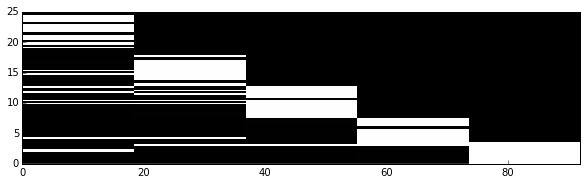

In [191]:
plt.figure(figsize=(10, 6))
plt.imshow(data_matrix, extent=[0,data_matrix.shape[0],0,data_matrix.shape[1] * 5], interpolation='none', cmap='gray')

As the plot shows, comparison is not really possible. It seems as if airlines change their flight numbers on a yearly basis. Thus we need to come up with another idea.

One of the easiest ideas is to average the delay time over each day and refine then.

In [209]:
dffordate = bigdf[bigdf.MONTH == query_month]
dffordate = dffordate[dffordate.DAY_OF_MONTH == query_day]
dffordate.head()

def predict_base_model(X):
    return np.array([dffordate.ARR_DELAY.mean()]*X.shape[0])

To test the quality of this model, we use the last year as test set and the previous as train data. The idea is, that we are always interested in predicting the next year somehow. Thus, if the match for 2014 is good, we expect it to be the same for 2015.

In [351]:
# build test/train set
df_train = dffordate[dffordate.YEAR != int(years[-1])]
df_test = dffordate[dffordate.YEAR == int(years[-1])]

In [352]:
y_train = df_train.ARR_DELAY
X_train = y_train # here dummy
y_test = df_test.ARR_DELAY
X_test = y_test # here dummy

In the base model, the prediction for 2014 is that we are going to be 27.72minutes late

In [216]:
y_pred = predict_base_model(X_test)
y_pred[0]

27.728260869565219

How good did it perform comparing the actual arrival delay?

In [220]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

In [221]:
rmse(y_test, y_pred)

44.10756003440288

# taking out seasonality

Flights are hugely impacted by weather conditions. 

In [232]:
%%time
from datetime import datetime

def addDayOfYear(df):
    # add day of year to datarows
    df['DAY_OF_YEAR'] = 0
    for index, row in df.iterrows():
        datestr = row['FL_DATE']
        dtobj = datetime.strptime(datestr, '%Y-%m-%d')
        df.set_value(index, 'DAY_OF_YEAR', dtobj.timetuple().tm_yday)
    return df

# add to bigdf!
bigdf = addDayOfYear(bigdf)

CPU times: user 3.58 s, sys: 70 ms, total: 3.64 s
Wall time: 3.89 s


In [263]:
# for our detrending we also add a day counter over time!
# convert therefore the flight date to datetime object
bigdf.FL_DATE = pd.to_datetime(bigdf.FL_DATE)

mindate = bigdf.FL_DATE.min()

bigdf['DAY_COUNTER'] = bigdf.FL_DATE - mindate
bigdf['DAY_COUNTER'] = bigdf['DAY_COUNTER'].apply(lambda d: (d / np.timedelta64(1,'D')).astype(int))

In [264]:
bigdf.head()

,Unnamed: 0,index,ORIGIN_CITY_NAME,ARR_DEL15,FL_NUM,AIRLINE_ID,ARR_DELAY,DIVERTED,DAY_OF_MONTH,DEST_CITY_NAME,...,ORIGIN_STATE_NM,MONTH,UNIQUE_CARRIER,ORIGIN_WAC,TAIL_NUM,AIRCRAFT_YEAR,AIRCRAFT_MFR,AIRCRAFT_AGE,DAY_OF_YEAR,DAY_COUNTER
0,0,24788,"New York, NY",0,301,19805,-23,0,12,"Chicago, IL",...,New York,1,AA,22,631AA,1990,BOEING,20,12,11
1,1,24789,"New York, NY",0,301,19805,-22,0,13,"Chicago, IL",...,New York,1,AA,22,621AA,1975,CESSNA,35,13,12
2,2,24792,"New York, NY",0,301,19805,-30,0,17,"Chicago, IL",...,New York,1,AA,22,614AA,1989,BOEING,21,17,16
3,3,24802,"New York, NY",0,301,19805,2,0,28,"Chicago, IL",...,New York,1,AA,22,630AA,1990,BOEING,20,28,27
4,4,24808,"New York, NY",0,303,19805,-12,0,5,"Chicago, IL",...,New York,1,AA,22,433AA,1987,MCDONNELL DOUGLAS,23,5,4


In [265]:
# compute average delay time for each day in the time series (do this not for 2014!)
g_dc = bigdf[bigdf.YEAR != int(years[-1])].groupby('DAY_COUNTER')

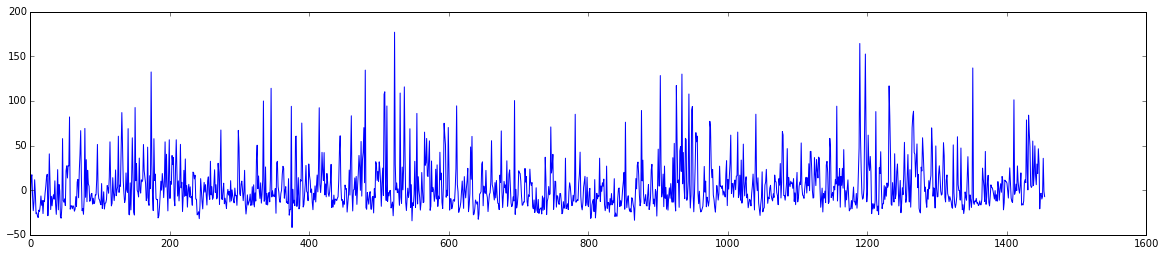

In [273]:
plt.figure(figsize=(20, 4))
plt.plot(g_dc.ARR_DELAY.mean())
daily_time_series = g_dc.ARR_DELAY.mean()

Interestingly for this route we see that delays in summer are highest. We can split this time series into a yearly and weekly component using moving average

In [400]:
%%time
g_wdoy = bigdf[bigdf.YEAR != int(years[-1])].groupby('DAY_OF_WEEK')
week_day_component = g_wdoy.ARR_DELAY.mean().values

# detrend it
bigdf['ARR_DELAY_WD'] = 0
for index, row in bigdf.iterrows():
    bigdf.set_value(index, 'ARR_DELAY_WD', row.ARR_DELAY  + week_day_component[row.DAY_OF_WEEK-1])

CPU times: user 3.84 s, sys: 66.2 ms, total: 3.91 s
Wall time: 4.15 s


In [407]:
g_doy = bigdf[bigdf.YEAR != int(years[-1])].groupby('DAY_OF_YEAR')
day_component = g_doy.ARR_DELAY.mean().values

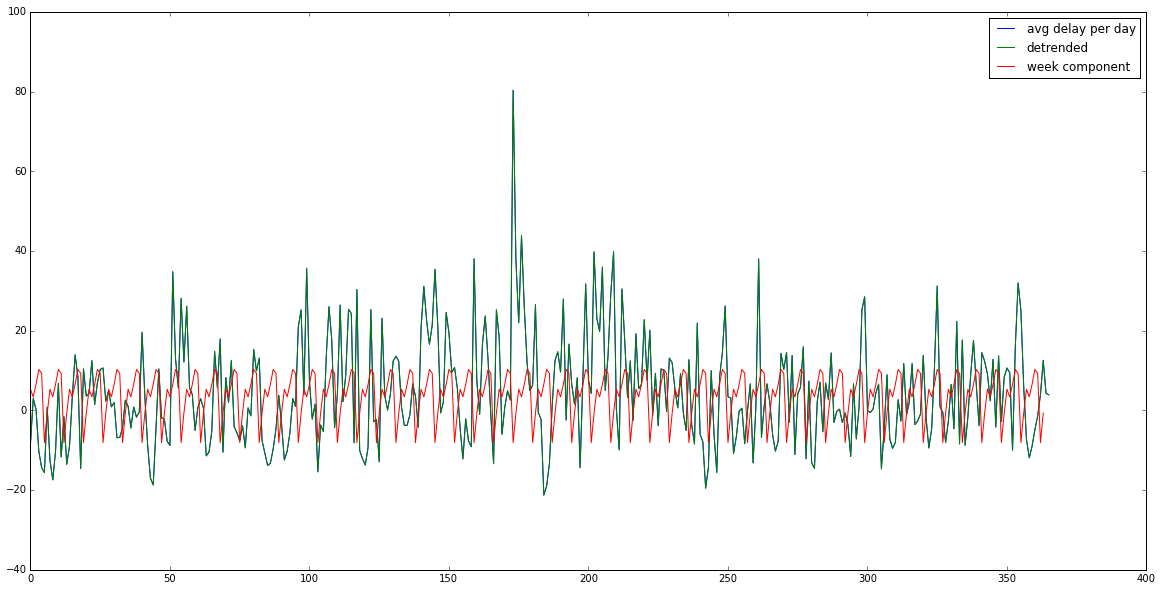

In [408]:
test = list(week_day_component)*53
test = test[1:367]
plt.figure(figsize=(20, 10))
plt.plot(day_component, label='avg delay per day')
plt.plot(g_doy.ARR_DELAY.mean(), label='detrended')
plt.plot(list(week_day_component)*52, label='week component')
plt.legend(loc='best')

With this, we can train a new predictor, using averages depending on day of week and the detrended component

In [409]:
# build test/train set
df_train = bigdf[bigdf.YEAR != int(years[-1])]
df_test = bigdf[bigdf.YEAR == int(years[-1])]
        
y_train = df_train.ARR_DELAY
X_train = df_train['FL_DATE'] # input is the flight date
y_test = df_test.ARR_DELAY
X_test = df_test['FL_DATE'] 

In [416]:
def predictDelayTime(X):
    y_pred = []
    for x in X:
        dtobj = x.to_datetime()
        day_of_year = dtobj.timetuple().tm_yday
        day_of_week = dtobj.timetuple().tm_wday
        y_val = week_day_component[day_of_week - 1] + day_component[day_of_year - 1]
        y_pred.append(y_val)
    
    return np.array(y_pred)

In [417]:
y_pred = predictDelayTime(X_test)

In [418]:
# check error
rmse(y_test, y_pred)

49.06014228791684